In [1]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [2]:
from transforms import *

from torchvision.datasets import Cityscapes
from datasets import A2D2Dataset

a2d2_root = ".\\data\\a2d2\\"
cityscapes_root = ".\\data\\cityscapes"

#A2D2

# train_dataset = A2D2Dataset(
#     root=a2d2_root,
#     split='train',
#     transforms=alb_wrapper
    
# )

# test_dataset = A2D2Dataset(
#     root=a2d2_root,
#     split='val',
#     transforms=alb_wrapper
# )

# Cityscapes

train_dataset = Cityscapes(
    root=cityscapes_root,
    split='train',
    target_type="semantic",
    transforms=alb_wrapper
)

test_dataset = Cityscapes(
    root=cityscapes_root,
    split='val',
    target_type="semantic",
    transforms=alb_wrapper
)

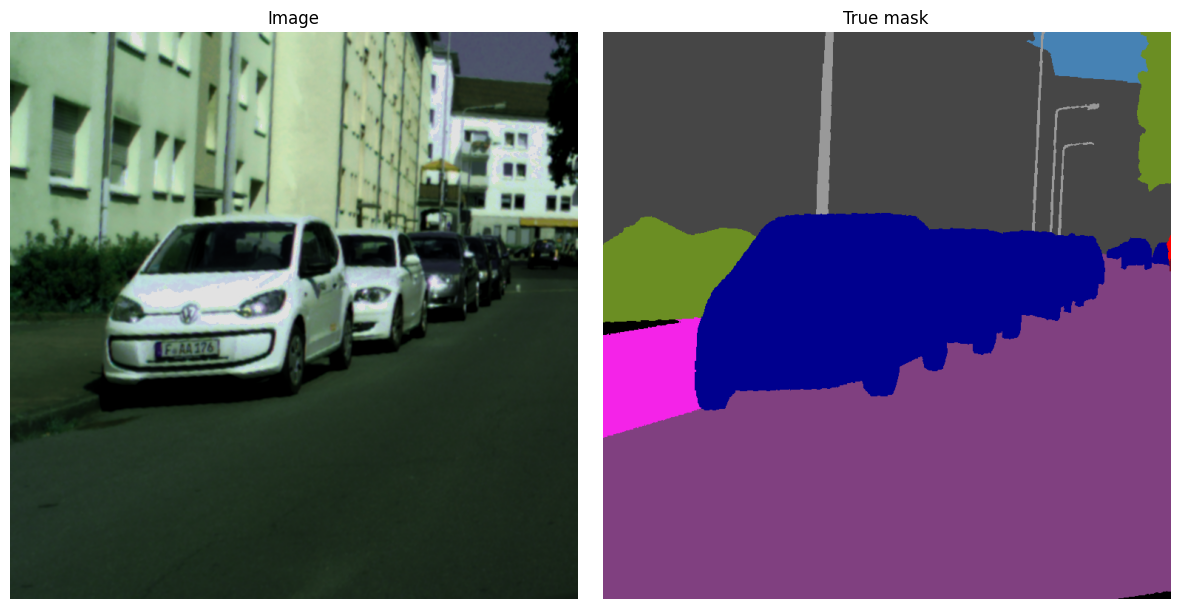

In [3]:
from utils.image import *

import matplotlib.pyplot as plt
import numpy as np

palette = extract_palette(test_dataset)
image, mask = test_dataset[1]

display_image_and_mask(image=image, mask_true=mask, mask_palette=palette)

In [4]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=12, 
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4, 
    pin_memory=True,
    drop_last=True
)

In [5]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from torch.optim import lr_scheduler

class UnetModel(pl.LightningModule):
    def __init__(self, encoder_weights, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.Unet(
            encoder_weights=encoder_weights,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        # Preprocessing parameters for image normalization
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.number_of_classes = out_classes
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # Loss function for multi-class segmentation
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True, ignore_index=255)

        # Step metrics tracking
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

        self.temp_train_data = {}

    def forward(self, image):
        # Normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Ensure that image dimensions are correct
        assert image.ndim == 4  # [batch_size, channels, H, W]

        mask = mask.long()

        if mask.ndim == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)    # teraz [B,H,W]

        assert mask.ndim == 3, f"Oczekiwano mask.ndim==3, a mamy {mask.ndim}"

        # Predict mask logits
        logits_mask = self.forward(image)

        assert (
            logits_mask.shape[1] == self.number_of_classes
        )  # [batch_size, number_of_classes, H, W]

        # Ensure the logits mask is contiguous
        logits_mask = logits_mask.contiguous()

        # Compute loss using multi-class Dice loss (pass original mask, not one-hot encoded)
        loss = self.loss_fn(logits_mask, mask)

        # Apply softmax to get probabilities for multi-class segmentation
        prob_mask = logits_mask.softmax(dim=1)

        # Convert probabilities to predicted class labels
        pred_mask = prob_mask.argmax(dim=1)

        # Compute true positives, false positives, false negatives, and true negatives
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes, ignore_index=255
        )

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage: str):
        # sanity-check
        if len(outputs) == 0:
            return

        # batch stats
        tp = torch.cat([o["tp"] for o in outputs])   #  [N,C]
        fp = torch.cat([o["fp"] for o in outputs])
        fn = torch.cat([o["fn"] for o in outputs])
        tn = torch.cat([o["tn"] for o in outputs])

        # mIoU
        miou_dataset = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        miou_image = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        self.temp_train_data.update({
                f"{stage}_miou_dataset": miou_dataset.detach(),
                f"{stage}_miou_image": miou_image.detach()
            })

        # per-class IoU
        per_class = smp.metrics.iou_score(tp, fp, fn, tn, reduction="none")
        if per_class.ndim == 2:
            per_class = per_class.mean(dim=0)

        # logging
        if stage == "val":
            for cid, val in enumerate(per_class):
                self.temp_train_data.update({
                    f"iou_cls{cid}": val.item()
                })
            
        self.log(f"{stage}_miou",
            miou_dataset,
            prog_bar=True, logger=False, on_step=False, on_epoch=True)
            
    def save_log(self):
        for name, value in self.temp_train_data.items():
            self.log(
                name=name,
                value=value,
                prog_bar=False,
                logger=True,
                on_step=False,
                on_epoch=True
            )
        self.temp_train_data.clear()

    def training_step(self, batch, batch_idx):
        out = self.shared_step(batch, "train")
        self.training_step_outputs.append(out)
        self.temp_train_data.update({"train_loss": out["loss"]})
        return out

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.save_log()
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        out = self.shared_step(batch, "val")
        self.validation_step_outputs.append(out)
        self.temp_train_data.update({"val_loss": out["loss"]})
        return out

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "val")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [6]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pytorch_lightning.loggers import CSVLogger

EPOCHS = 50
T_MAX = EPOCHS * len(train_loader)

OUT_CLASSES = len(train_dataset.classes) + 1

model = UnetModel(
    encoder_weights="imagenet",
    encoder_name="resnext50_32x4d",
    in_channels=3,
    out_classes=OUT_CLASSES
)

logger  = CSVLogger("logs", name="cityscapes") 
trainer = pl.Trainer(max_epochs=EPOCHS, logger=logger, precision=16)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
)

c:\Users\fhcar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\fhcar\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## Przykłady interferencji
Poniższy kod prezentuje przykłady interferencji.
- Interferencja na `test_dataset` z wyświetlaniem maski rzeczywistej.
- Interferencja na pojedyńczym obrazie ze zbioru testowego.
- Interferencja na własnym obrazie.

In [7]:
import torch
from utils.image import *

# Załadowanie modelu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

palette = extract_palette(train_dataset)
OUT_CLASSES = len(train_dataset.classes)

model = UnetModel.load_from_checkpoint(
    checkpoint_path=".\\logs\\cityscapes\\version_0\\checkpoints\\epoch=49-step=37150.ckpt",
    encoder_weights="imagenet",
    encoder_name="resnext50_32x4d",
    in_channels=3,
    out_classes=OUT_CLASSES
)

model = model.to(device)

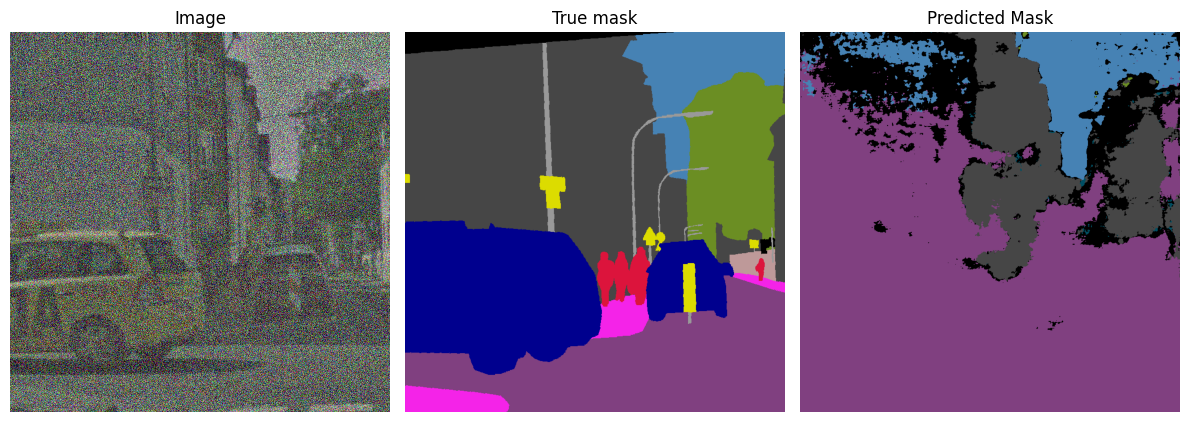

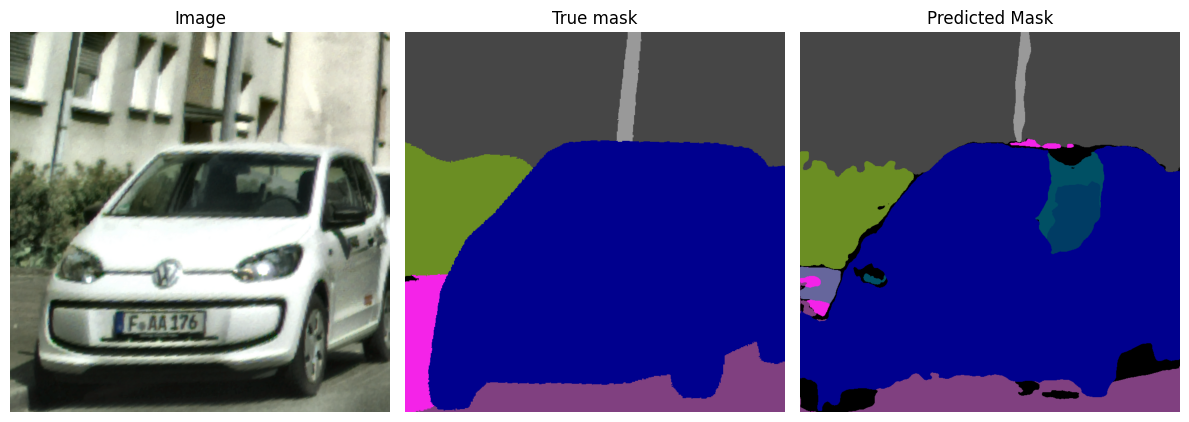

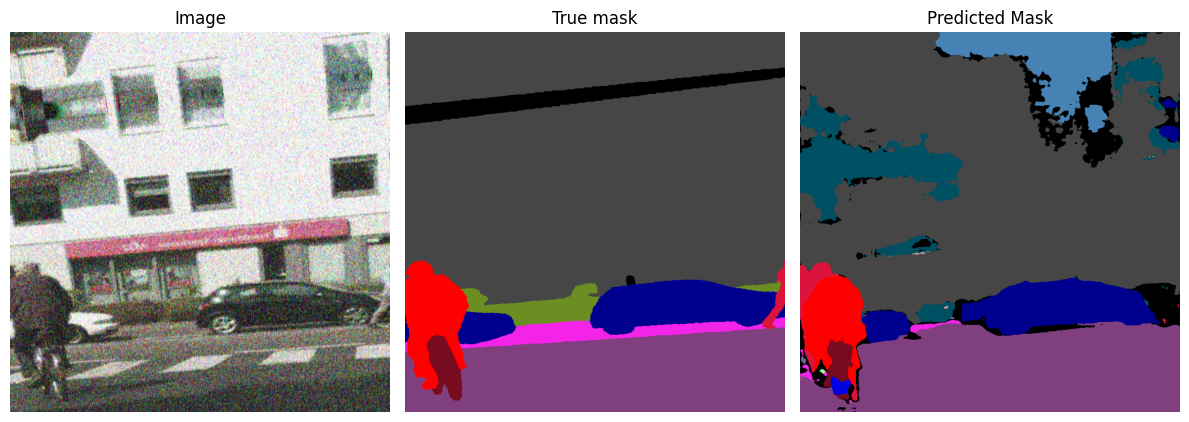

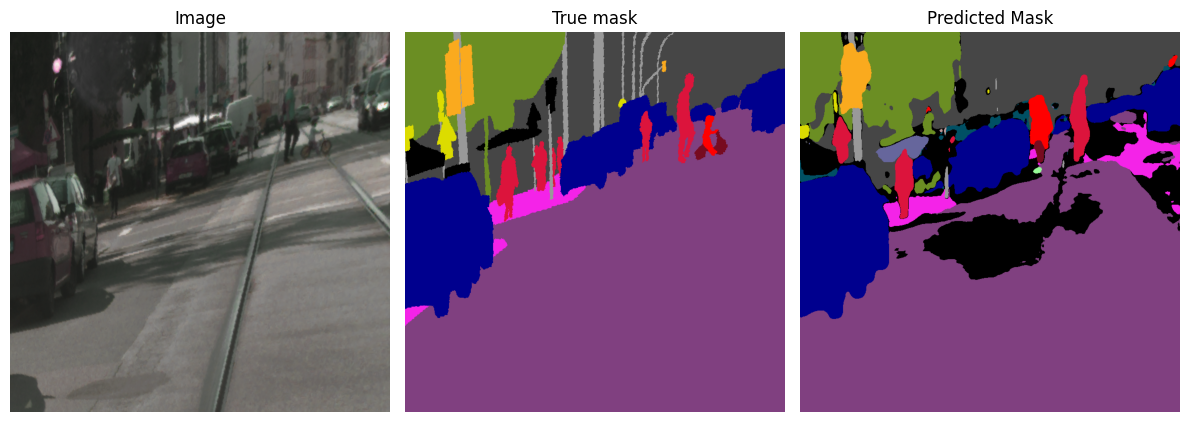

In [8]:
import torch
from utils.image import *

images, masks = next(iter(test_loader))
images = images.to(device)
masks  = masks.to(device)

masks = masks.squeeze(1)

with torch.inference_mode():
    model.eval()
    logits = model(images)

pr_masks = logits.softmax(dim=1).argmax(dim=1)

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx > 4:  # Visualize first 5 samples
        break

    img_cpu  = image.cpu().numpy().transpose(1,2,0)
    gt_cpu   = gt_mask.cpu().numpy()      # (H,W)
    pred_cpu = pr_mask.cpu().numpy()      # (H,W)

    display_image_and_mask(
        image=img_cpu,
        mask_true=gt_cpu,
        mask_pred=pred_cpu,
        mask_palette=palette
    )

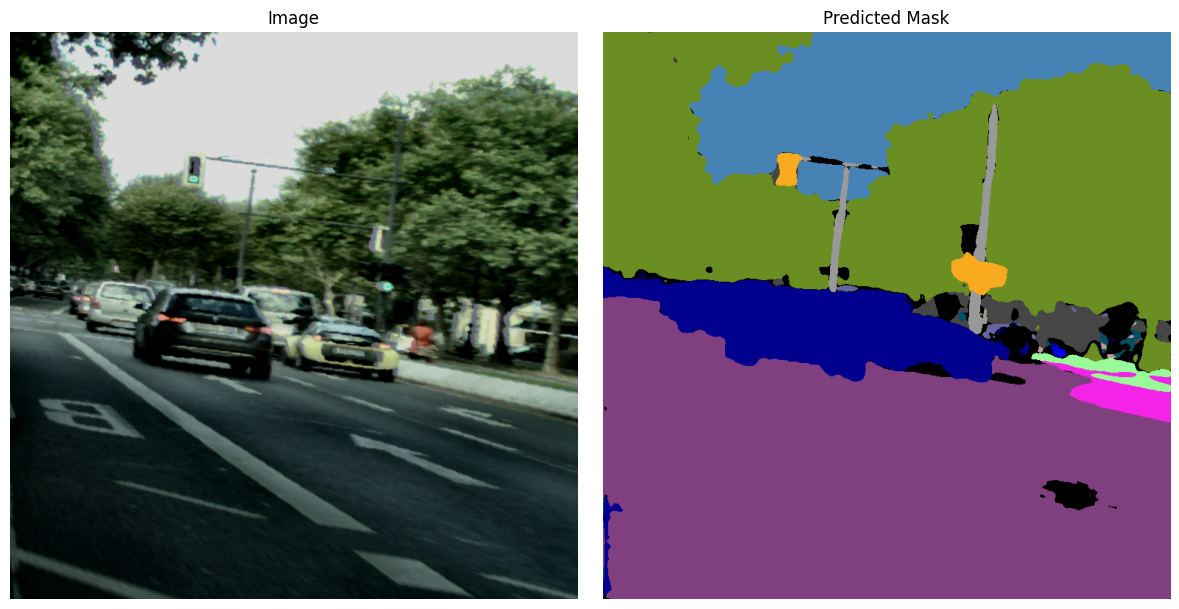

In [ ]:
import torch
from torch.utils.data import DataLoader
from utils.image import *

test_dataset = Cityscapes(
    root=cityscapes_root,
    split='test',
    target_type="semantic",
    transforms=alb_wrapper
)

single_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

# Inference

images, _ = next(iter(single_loader))
images = images.to(device)

with torch.inference_mode():
    logits = model(images)

pr_masks = logits.softmax(1).argmax(1)

display_image_and_mask(
    image=images[0], 
    mask_pred=pr_masks[0], 
    mask_palette=palette
)


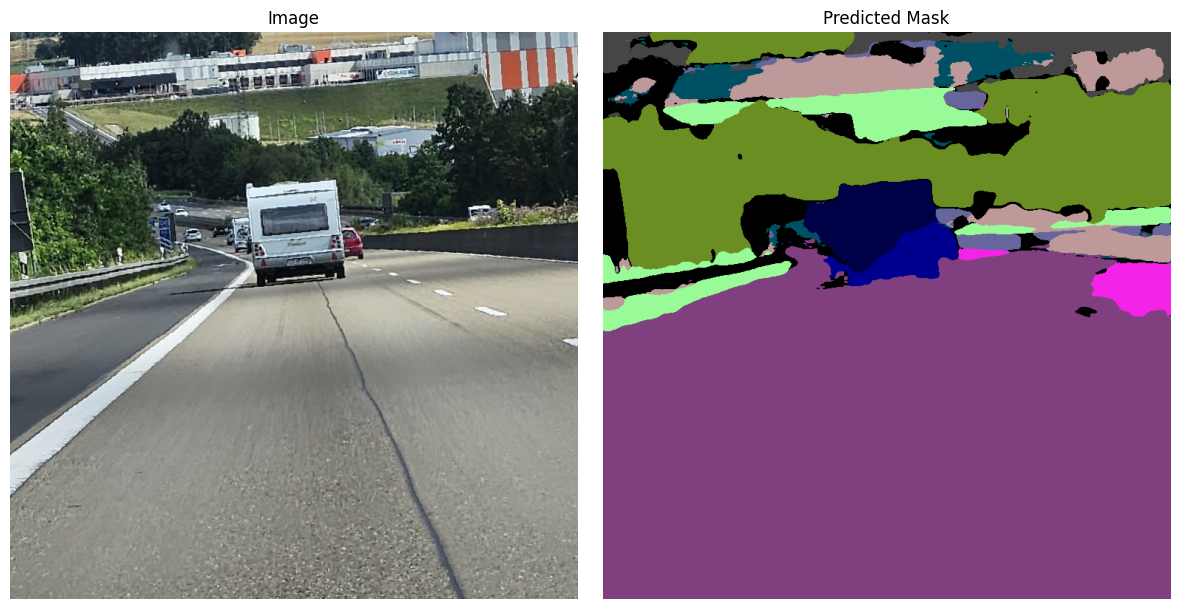

In [ ]:
import torch
from PIL import Image
from utils.image import *

# Inference

pil_image = Image.open(r".\test\test2.png")

aug_image = transforms_test(image=np.asarray(pil_image))
tensor_image = aug_image['image'].float() / 255.
tensor_image = tensor_image.to(device)

with torch.inference_mode():
    logits = model(tensor_image)
    
pr_mask = logits.softmax(1).argmax(1)

display_image_and_mask(
    image=tensor_image, 
    mask_pred=pr_mask, 
    mask_palette=palette
)